In [21]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from dataloader.depthloader import load_calib_cam_to_cam, disparity_loader
from utils.flowlib import read_flow, flow_to_image

In [22]:
data_path = '/home/viplab/kitti/data_scene_flow' # replace with path to kitti data sceneflow
pred_path = './precomputed/exp-kitti-train'
calib_path = '/home/viplab/kitti/data_scene_flow_calib' # replace with path to kitti sceneflow calibration

In [23]:
def disp_depth(var1, bl, k):
    return bl*k/var1

def tau_to_ttc(tau):
    return (0.1/(1-tau))

Test One

In [24]:
d1_errs = []
d2_errs = []
fl_errs = []
sf_err = [] 

for idnum in range(0,150, 1):
    impath = '%s/training/image_2/%06d_10.png'%(data_path,idnum)
    framename = int(impath.split('/')[-1].split('_')[-2])

    flow_gt = read_flow('%s/training/flow_occ/%06d_10.png'%(data_path,framename)).astype(np.float32)
    disp0_gt = disparity_loader('%s/training/disp_occ_0/%06d_10.png'%(data_path,idnum))
    d1mask_gt = disp0_gt>0
    disp1_gt = disparity_loader('%s/training/disp_occ_1/%06d_10.png'%(data_path,idnum))
    d2mask_gt = disp1_gt>0
    shape = flow_gt.shape[:2]

    im = cv2.imread('%s/training/image_2/%06d_10.png'%(data_path,framename))
    im_nf = cv2.imread('%s/training/image_2/%06d_11.png'%(data_path,framename))
    ints = load_calib_cam_to_cam('%s/training/calib_cam_to_cam/%06d.txt'%(calib_path,framename))
    K0 = ints['K_cam2']
    bl = ints['b20']-ints['b30']
    K1 = K0.copy()

    flow = read_flow('%s/2015/flo-%06d_10.pfm'%(pred_path,framename)).astype(np.float32)
    
    tau = np.exp(disparity_loader('%s/2015/mid-%06d_10.pfm'%(pred_path,framename)))

    tau0 = np.load(f'fpttc_tau0/{framename}_eta_out.npy')
    tau1 = np.load(f'fpttc_tau1/{framename}_eta_out.npy')
    ttc0 = tau_to_ttc(tau0)
    ttc1 = tau_to_ttc(tau1)

    m3d_depth_0 = np.load(f'Metric3d_depths/{framename}_10.npy')
    m3d_disp_0 = disp_depth(m3d_depth_0, bl, K0[0][0])

    m3d_depth_1 = np.load(f'Metric3d_depths/{framename}_11.npy')
    m3d_disp_1 = disp_depth(m3d_depth_1, bl, K0[0][0])
    disp0_mono = disparity_loader('./precomputed/monodepth2/2015/%06d_10_disp.pfm'%(framename))

    if m3d_depth_0.shape != (375,1242) or disp0_mono.shape != (375,1242):
        print("skip")
        continue
    velocity0 = m3d_depth_0/ttc0


    ttc_depth0 = velocity0*ttc0

    ### TEST ONE ####
    disp0 = disp0_mono
    disp1 = disp0/tau1

    # compute errors
    d1err = np.abs(disp0-disp0_gt)
    d1err = np.logical_and(d1err>=3, d1err/disp0_gt>=0.05)
    d1err[~d1mask_gt]=0
    d1_errs.append(d1err[d1mask_gt])
      
    d2err = np.abs(disp1-disp1_gt)
    d2err = np.logical_and(d2err>=3, d2err/disp1_gt>=0.05)
    d2err[~d2mask_gt]=0
    d2_errs.append(d2err[d2mask_gt])
    
    epe_map = np.sqrt(np.power(flow_gt[:,:,:2] - flow[:,:,:2],2).sum(-1))
    gt_mag_map = np.sqrt(np.power(flow_gt[:,:,:2],2).sum(-1))
    flerr = np.logical_and(epe_map > 3, epe_map/gt_mag_map > 0.05)
    fl_errs.append( flerr[flow_gt[:,:,-1].astype(bool)]  )
    
    sf_err += list(np.logical_or(np.logical_or(flerr[flow_gt[:,:,-1].astype(bool)],d2err[flow_gt[:,:,-1].astype(bool)]),d1err[flow_gt[:,:,-1].astype(bool)]))

print('d1-err:%.2f'%(np.mean(np.concatenate(d1_errs))*100))
print('d2-err:%.2f'%(np.mean(np.concatenate(d2_errs))*100))
print('fl-err:%.2f'%(np.mean(np.concatenate(fl_errs))*100))
print('sf-err:%.2f'%(np.mean(sf_err)*100))

/tmp/ipykernel_3920647/3300800032.py:54: RuntimeWarning: divide by zero encountered in divide
  d1err = np.logical_and(d1err>=3, d1err/disp0_gt>=0.05)
/tmp/ipykernel_3920647/3300800032.py:59: RuntimeWarning: divide by zero encountered in divide
  d2err = np.logical_and(d2err>=3, d2err/disp1_gt>=0.05)
/tmp/ipykernel_3920647/3300800032.py:65: RuntimeWarning: divide by zero encountered in divide
  flerr = np.logical_and(epe_map > 3, epe_map/gt_mag_map > 0.05)
/tmp/ipykernel_3920647/2670584550.py:5: RuntimeWarning: divide by zero encountered in divide
  return (0.1/(1-tau))
/tmp/ipykernel_3920647/3300800032.py:46: RuntimeWarning: invalid value encountered in multiply
  ttc_depth0 = velocity0*ttc0


d1-err:13.35
d2-err:17.17
fl-err:5.29
sf-err:19.50


Test Two

In [25]:
d1_errs = []
d2_errs = []
fl_errs = []
sf_err = [] 

for idnum in range(0,150, 1):
    impath = '%s/training/image_2/%06d_10.png'%(data_path,idnum)
    framename = int(impath.split('/')[-1].split('_')[-2])

    flow_gt = read_flow('%s/training/flow_occ/%06d_10.png'%(data_path,framename)).astype(np.float32)
    disp0_gt = disparity_loader('%s/training/disp_occ_0/%06d_10.png'%(data_path,idnum))
    d1mask_gt = disp0_gt>0
    disp1_gt = disparity_loader('%s/training/disp_occ_1/%06d_10.png'%(data_path,idnum))
    d2mask_gt = disp1_gt>0
    shape = flow_gt.shape[:2]

    im = cv2.imread('%s/training/image_2/%06d_10.png'%(data_path,framename))
    im_nf = cv2.imread('%s/training/image_2/%06d_11.png'%(data_path,framename))
    ints = load_calib_cam_to_cam('%s/training/calib_cam_to_cam/%06d.txt'%(calib_path,framename))
    K0 = ints['K_cam2']
    bl = ints['b20']-ints['b30']
    K1 = K0.copy()

    flow = read_flow('%s/2015/flo-%06d_10.pfm'%(pred_path,framename)).astype(np.float32)
    
    tau = np.exp(disparity_loader('%s/2015/mid-%06d_10.pfm'%(pred_path,framename)))

    tau0 = np.load(f'fpttc_tau0/{framename}_eta_out.npy')
    tau1 = np.load(f'fpttc_tau1/{framename}_eta_out.npy')
    ttc0 = tau_to_ttc(tau0)
    ttc1 = tau_to_ttc(tau1)

    m3d_depth_0 = np.load(f'Metric3d_depths/{framename}_10.npy')
    m3d_disp_0 = disp_depth(m3d_depth_0, bl, K0[0][0])

    m3d_depth_1 = np.load(f'Metric3d_depths/{framename}_11.npy')
    m3d_disp_1 = disp_depth(m3d_depth_1, bl, K0[0][0])
    disp0_mono = disparity_loader('./precomputed/monodepth2/2015/%06d_10_disp.pfm'%(framename))

    if m3d_depth_0.shape != (375,1242) or disp0_mono.shape != (375,1242):
        print("skip")
        continue
    velocity0 = m3d_depth_0/ttc0

    ttc_depth0 = velocity0*ttc0

    ### TEST TWO ####
    velocity0 = m3d_depth_0*ttc0
    ttc_depth0 = velocity0/ttc0
    ttc_disp0 = disp_depth(ttc_depth0, bl, K0[0][0])
    disp0 = ttc_disp0
    disp1 = disp0/tau0

    # compute errors
    d1err = np.abs(disp0-disp0_gt)
    d1err = np.logical_and(d1err>=3, d1err/disp0_gt>=0.05)
    d1err[~d1mask_gt]=0
    d1_errs.append(d1err[d1mask_gt])
      
    d2err = np.abs(disp1-disp1_gt)
    d2err = np.logical_and(d2err>=3, d2err/disp1_gt>=0.05)
    d2err[~d2mask_gt]=0
    d2_errs.append(d2err[d2mask_gt])
    
    epe_map = np.sqrt(np.power(flow_gt[:,:,:2] - flow[:,:,:2],2).sum(-1))
    gt_mag_map = np.sqrt(np.power(flow_gt[:,:,:2],2).sum(-1))
    flerr = np.logical_and(epe_map > 3, epe_map/gt_mag_map > 0.05)
    fl_errs.append( flerr[flow_gt[:,:,-1].astype(bool)]  )
    
    sf_err += list(np.logical_or(np.logical_or(flerr[flow_gt[:,:,-1].astype(bool)],d2err[flow_gt[:,:,-1].astype(bool)]),d1err[flow_gt[:,:,-1].astype(bool)]))

print('d1-err:%.2f'%(np.mean(np.concatenate(d1_errs))*100))
print('d2-err:%.2f'%(np.mean(np.concatenate(d2_errs))*100))
print('fl-err:%.2f'%(np.mean(np.concatenate(fl_errs))*100))
print('sf-err:%.2f'%(np.mean(sf_err)*100))

/tmp/ipykernel_3920647/704115288.py:56: RuntimeWarning: divide by zero encountered in divide
  d1err = np.logical_and(d1err>=3, d1err/disp0_gt>=0.05)
/tmp/ipykernel_3920647/704115288.py:61: RuntimeWarning: divide by zero encountered in divide
  d2err = np.logical_and(d2err>=3, d2err/disp1_gt>=0.05)
/tmp/ipykernel_3920647/704115288.py:67: RuntimeWarning: divide by zero encountered in divide
  flerr = np.logical_and(epe_map > 3, epe_map/gt_mag_map > 0.05)
/tmp/ipykernel_3920647/2670584550.py:5: RuntimeWarning: divide by zero encountered in divide
  return (0.1/(1-tau))
/tmp/ipykernel_3920647/704115288.py:45: RuntimeWarning: invalid value encountered in multiply
  ttc_depth0 = velocity0*ttc0
/tmp/ipykernel_3920647/704115288.py:49: RuntimeWarning: invalid value encountered in divide
  ttc_depth0 = velocity0/ttc0


d1-err:14.32
d2-err:19.06
fl-err:5.29
sf-err:22.24


Test Three

In [26]:
d1_errs = []
d2_errs = []
fl_errs = []
sf_err = [] 

for idnum in range(0,150, 1):
    impath = '%s/training/image_2/%06d_10.png'%(data_path,idnum)
    framename = int(impath.split('/')[-1].split('_')[-2])

    flow_gt = read_flow('%s/training/flow_occ/%06d_10.png'%(data_path,framename)).astype(np.float32)
    disp0_gt = disparity_loader('%s/training/disp_occ_0/%06d_10.png'%(data_path,idnum))
    d1mask_gt = disp0_gt>0
    disp1_gt = disparity_loader('%s/training/disp_occ_1/%06d_10.png'%(data_path,idnum))
    d2mask_gt = disp1_gt>0
    shape = flow_gt.shape[:2]

    im = cv2.imread('%s/training/image_2/%06d_10.png'%(data_path,framename))
    im_nf = cv2.imread('%s/training/image_2/%06d_11.png'%(data_path,framename))
    ints = load_calib_cam_to_cam('%s/training/calib_cam_to_cam/%06d.txt'%(calib_path,framename))
    K0 = ints['K_cam2']
    bl = ints['b20']-ints['b30']
    K1 = K0.copy()

    flow = read_flow('%s/2015/flo-%06d_10.pfm'%(pred_path,framename)).astype(np.float32)
    
    tau = np.exp(disparity_loader('%s/2015/mid-%06d_10.pfm'%(pred_path,framename)))

    tau0 = np.load(f'fpttc_tau0/{framename}_eta_out.npy')
    tau1 = np.load(f'fpttc_tau1/{framename}_eta_out.npy')
    ttc0 = tau_to_ttc(tau0)
    ttc1 = tau_to_ttc(tau1)

    m3d_depth_0 = np.load(f'Metric3d_depths/{framename}_10.npy')
    m3d_disp_0 = disp_depth(m3d_depth_0, bl, K0[0][0])

    m3d_depth_1 = np.load(f'Metric3d_depths/{framename}_11.npy')
    m3d_disp_1 = disp_depth(m3d_depth_1, bl, K0[0][0])
    disp0_mono = disparity_loader('./precomputed/monodepth2/2015/%06d_10_disp.pfm'%(framename))

    if m3d_depth_0.shape != (375,1242) or disp0_mono.shape != (375,1242):
        print("skip")
        continue
    velocity0 = m3d_depth_0/ttc0


    ttc_depth0 = velocity0*ttc0

    ##### TEST THREE #####
    disp0 = m3d_disp_0
    disp1 = disp0/tau
    
    # compute errors
    d1err = np.abs(disp0-disp0_gt)
    d1err = np.logical_and(d1err>=3, d1err/disp0_gt>=0.05)
    d1err[~d1mask_gt]=0
    d1_errs.append(d1err[d1mask_gt])
      
    d2err = np.abs(disp1-disp1_gt)
    d2err = np.logical_and(d2err>=3, d2err/disp1_gt>=0.05)
    d2err[~d2mask_gt]=0
    d2_errs.append(d2err[d2mask_gt])
    
    epe_map = np.sqrt(np.power(flow_gt[:,:,:2] - flow[:,:,:2],2).sum(-1))
    gt_mag_map = np.sqrt(np.power(flow_gt[:,:,:2],2).sum(-1))
    flerr = np.logical_and(epe_map > 3, epe_map/gt_mag_map > 0.05)
    fl_errs.append( flerr[flow_gt[:,:,-1].astype(bool)]  )
    
    sf_err += list(np.logical_or(np.logical_or(flerr[flow_gt[:,:,-1].astype(bool)],d2err[flow_gt[:,:,-1].astype(bool)]),d1err[flow_gt[:,:,-1].astype(bool)]))

print('d1-err:%.2f'%(np.mean(np.concatenate(d1_errs))*100))
print('d2-err:%.2f'%(np.mean(np.concatenate(d2_errs))*100))
print('fl-err:%.2f'%(np.mean(np.concatenate(fl_errs))*100))
print('sf-err:%.2f'%(np.mean(sf_err)*100))

/tmp/ipykernel_3920647/2376506502.py:54: RuntimeWarning: divide by zero encountered in divide
  d1err = np.logical_and(d1err>=3, d1err/disp0_gt>=0.05)
/tmp/ipykernel_3920647/2376506502.py:59: RuntimeWarning: divide by zero encountered in divide
  d2err = np.logical_and(d2err>=3, d2err/disp1_gt>=0.05)
/tmp/ipykernel_3920647/2376506502.py:65: RuntimeWarning: divide by zero encountered in divide
  flerr = np.logical_and(epe_map > 3, epe_map/gt_mag_map > 0.05)
/tmp/ipykernel_3920647/2670584550.py:5: RuntimeWarning: divide by zero encountered in divide
  return (0.1/(1-tau))
/tmp/ipykernel_3920647/2376506502.py:46: RuntimeWarning: invalid value encountered in multiply
  ttc_depth0 = velocity0*ttc0


d1-err:14.32
d2-err:16.76
fl-err:5.29
sf-err:19.92


Alpha optimization Test 4

In [27]:
alphas = np.linspace(0, 1, 20)
d1_errss = [] 
d2_errss = [] 
fl_errss = []
sf_errs = []

for alpha in alphas:
    d1_errs = []
    d2_errs = []
    fl_errs = []
    sf_err = []
    for idnum in range(0,150, 1):
        impath = '%s/training/image_2/%06d_10.png'%(data_path,idnum)
        framename = int(impath.split('/')[-1].split('_')[-2])

        flow_gt = read_flow('%s/training/flow_occ/%06d_10.png'%(data_path,framename)).astype(np.float32)
        disp0_gt = disparity_loader('%s/training/disp_occ_0/%06d_10.png'%(data_path,idnum))
        d1mask_gt = disp0_gt>0
        disp1_gt = disparity_loader('%s/training/disp_occ_1/%06d_10.png'%(data_path,idnum))
        d2mask_gt = disp1_gt>0
        shape = flow_gt.shape[:2]

        im = cv2.imread('%s/training/image_2/%06d_10.png'%(data_path,framename))
        im_nf = cv2.imread('%s/training/image_2/%06d_11.png'%(data_path,framename))
        ints = load_calib_cam_to_cam('%s/training/calib_cam_to_cam/%06d.txt'%(calib_path,framename))
        K0 = ints['K_cam2']
        bl = ints['b20']-ints['b30']
        K1 = K0.copy()

        flow = read_flow('%s/2015/flo-%06d_10.pfm'%(pred_path,framename)).astype(np.float32)
        
        tau = np.exp(disparity_loader('%s/2015/mid-%06d_10.pfm'%(pred_path,framename)))

        tau0 = np.load(f'fpttc_tau0/{framename}_eta_out.npy')
        tau1 = np.load(f'fpttc_tau1/{framename}_eta_out.npy')
        ttc0 = tau_to_ttc(tau0)
        ttc1 = tau_to_ttc(tau1)

        m3d_depth_0 = np.load(f'Metric3d_depths/{framename}_10.npy')
        m3d_disp_0 = disp_depth(m3d_depth_0, bl, K0[0][0])

        m3d_depth_1 = np.load(f'Metric3d_depths/{framename}_11.npy')
        m3d_disp_1 = disp_depth(m3d_depth_1, bl, K0[0][0])
        disp0_mono = disparity_loader('./precomputed/monodepth2/2015/%06d_10_disp.pfm'%(framename))
        if m3d_depth_0.shape != (375,1242) or disp0_mono.shape != (375,1242):
            print("skip")
            continue
        velocity0 = m3d_depth_0/ttc0

        ttc_depth0 = velocity0*ttc0

        disp0 = alpha * disp0_mono + (1 - alpha) * m3d_disp_0
        disp1 = disp0/tau
        
        d1err = np.abs(disp0-disp0_gt)
        d1err = np.logical_and(d1err>=3, d1err/disp0_gt>=0.05)
        d1err[~d1mask_gt]=0
        d1_errs.append(d1err[d1mask_gt])
        
        d2err = np.abs(disp1-disp1_gt)
        d2err = np.logical_and(d2err>=3, d2err/disp1_gt>=0.05)
        d2err[~d2mask_gt]=0
        d2_errs.append(d2err[d2mask_gt])
        
        epe_map = np.sqrt(np.power(flow_gt[:,:,:2] - flow[:,:,:2],2).sum(-1))
        gt_mag_map = np.sqrt(np.power(flow_gt[:,:,:2],2).sum(-1))
        flerr = np.logical_and(epe_map > 3, epe_map/gt_mag_map > 0.05)
        fl_errs.append( flerr[flow_gt[:,:,-1].astype(bool)]  )
        
        sf_err += list(np.logical_or(np.logical_or(flerr[flow_gt[:,:,-1].astype(bool)],d2err[flow_gt[:,:,-1].astype(bool)]),d1err[flow_gt[:,:,-1].astype(bool)]))
    d1_errss.append(np.mean(np.concatenate(d1_errs))*100)
    d2_errss.append(np.mean(np.concatenate(d2_errs))*100)
    fl_errss.append(np.mean(np.concatenate(fl_errs))*100)
    sf_errs.append(np.mean(sf_err)*100)

/tmp/ipykernel_3920647/1271493380.py:56: RuntimeWarning: divide by zero encountered in divide
  d1err = np.logical_and(d1err>=3, d1err/disp0_gt>=0.05)
/tmp/ipykernel_3920647/1271493380.py:61: RuntimeWarning: divide by zero encountered in divide
  d2err = np.logical_and(d2err>=3, d2err/disp1_gt>=0.05)
/tmp/ipykernel_3920647/1271493380.py:67: RuntimeWarning: divide by zero encountered in divide
  flerr = np.logical_and(epe_map > 3, epe_map/gt_mag_map > 0.05)
/tmp/ipykernel_3920647/2670584550.py:5: RuntimeWarning: divide by zero encountered in divide
  return (0.1/(1-tau))
/tmp/ipykernel_3920647/1271493380.py:50: RuntimeWarning: invalid value encountered in multiply
  ttc_depth0 = velocity0*ttc0


Stats Vs Alpha values

minimizing alpha:0.5263157894736842


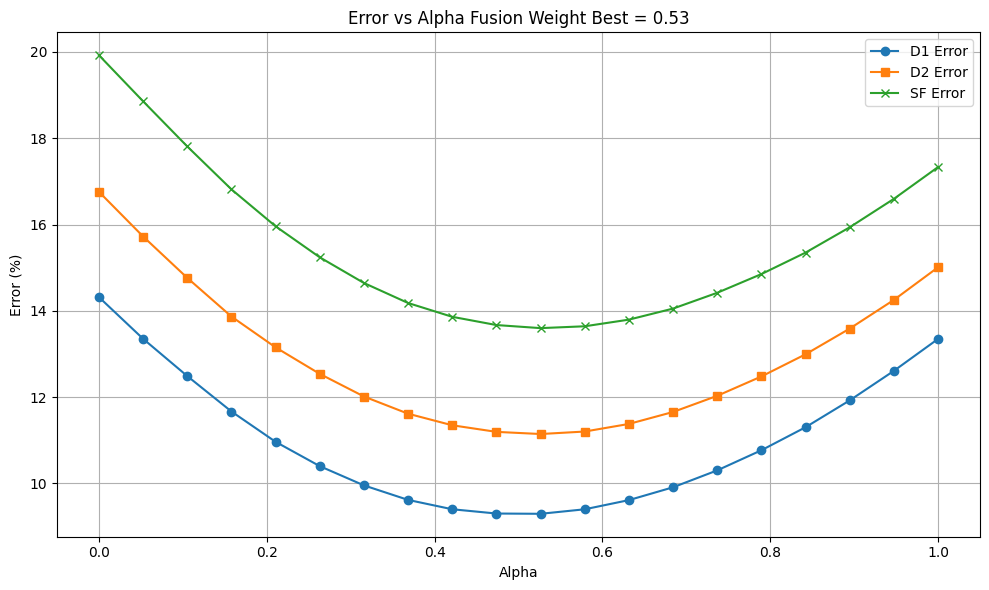

In [28]:
index = np.argmin(sf_errs)
print(f'minimizing alpha:{alphas[index]}')

plt.figure(figsize=(10,6))

plt.plot(alphas, d1_errss, label="D1 Error", marker='o')
plt.plot(alphas, d2_errss, label="D2 Error", marker='s')
plt.plot(alphas, sf_errs, label="SF Error", marker='x')

plt.xlabel("Alpha")
plt.ylabel("Error (%)")
plt.title(f"Error vs Alpha Fusion Weight Best = {alphas[index]:.02f}")
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

(np.float64(-0.5), np.float64(1241.5), np.float64(374.5), np.float64(-0.5))

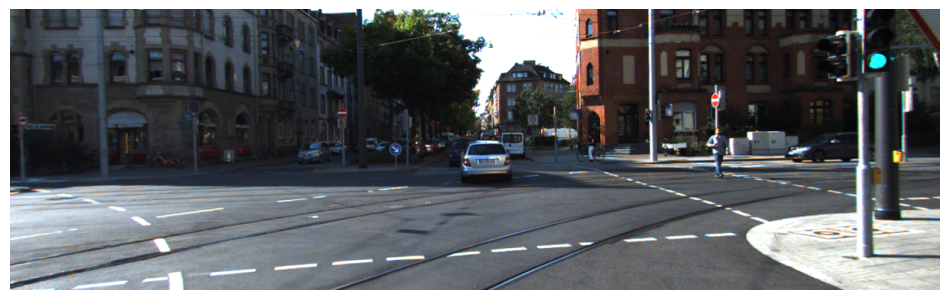

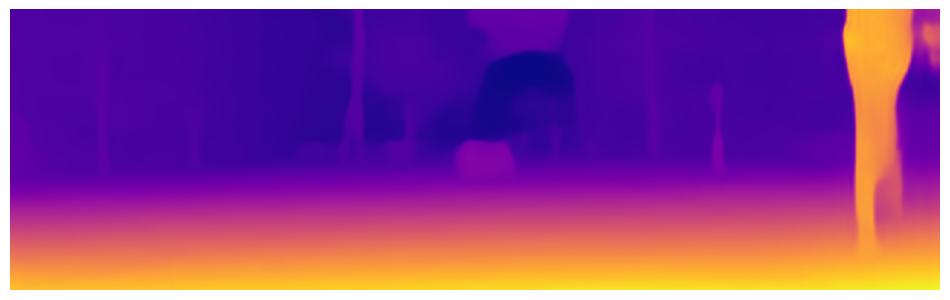

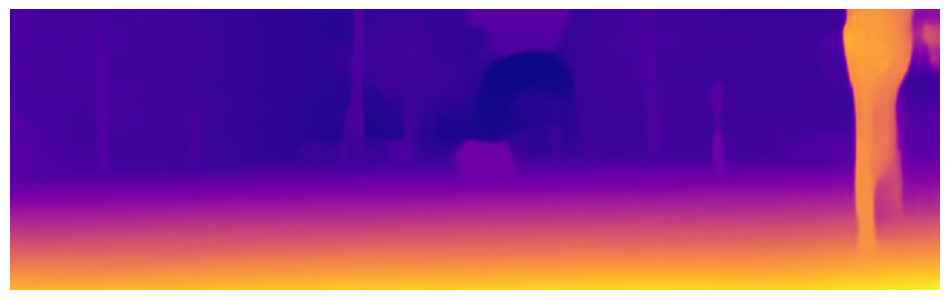

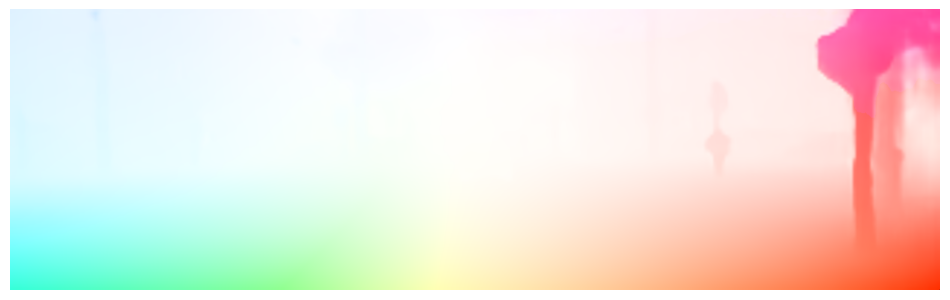

In [29]:
plt.figure(figsize=(12,4)); plt.imshow(im[:,:,::-1]); plt.axis('off')
plt.figure(figsize=(12,4)); plt.imshow(disp0,cmap='plasma'); plt.axis('off')
plt.figure(figsize=(12,4)); plt.imshow(disp1,cmap='plasma'); plt.axis('off')
plt.figure(figsize=(12,4)); plt.imshow(flow_to_image(flow),cmap='plasma'); plt.axis('off')

Test Four Alpha = 0.53

In [30]:
d1_errs = []
d2_errs = []
fl_errs = []
sf_err = [] 

for idnum in range(0,150, 1):
    impath = '%s/training/image_2/%06d_10.png'%(data_path,idnum)
    framename = int(impath.split('/')[-1].split('_')[-2])

    flow_gt = read_flow('%s/training/flow_occ/%06d_10.png'%(data_path,framename)).astype(np.float32)
    disp0_gt = disparity_loader('%s/training/disp_occ_0/%06d_10.png'%(data_path,idnum))
    d1mask_gt = disp0_gt>0
    disp1_gt = disparity_loader('%s/training/disp_occ_1/%06d_10.png'%(data_path,idnum))
    d2mask_gt = disp1_gt>0
    shape = flow_gt.shape[:2]

    im = cv2.imread('%s/training/image_2/%06d_10.png'%(data_path,framename))
    im_nf = cv2.imread('%s/training/image_2/%06d_11.png'%(data_path,framename))
    ints = load_calib_cam_to_cam('%s/training/calib_cam_to_cam/%06d.txt'%(calib_path,framename))
    K0 = ints['K_cam2']
    bl = ints['b20']-ints['b30']
    K1 = K0.copy()

    flow = read_flow('%s/2015/flo-%06d_10.pfm'%(pred_path,framename)).astype(np.float32)
    
    tau = np.exp(disparity_loader('%s/2015/mid-%06d_10.pfm'%(pred_path,framename)))

    tau0 = np.load(f'fpttc_tau0/{framename}_eta_out.npy')
    tau1 = np.load(f'fpttc_tau1/{framename}_eta_out.npy')
    ttc0 = tau_to_ttc(tau0)
    ttc1 = tau_to_ttc(tau1)

    m3d_depth_0 = np.load(f'Metric3d_depths/{framename}_10.npy')
    m3d_disp_0 = disp_depth(m3d_depth_0, bl, K0[0][0])

    m3d_depth_1 = np.load(f'Metric3d_depths/{framename}_11.npy')
    m3d_disp_1 = disp_depth(m3d_depth_1, bl, K0[0][0])
    disp0_mono = disparity_loader('./precomputed/monodepth2/2015/%06d_10_disp.pfm'%(framename))

    if m3d_depth_0.shape != (375,1242) or disp0_mono.shape != (375,1242):
        print("skip")
        continue
    velocity0 = m3d_depth_0/ttc0
    
    ttc_depth0 = velocity0*ttc0

    #### TEST FOUR ####
    alpha = 0.50
    disp0 = alpha * disp0_mono + (1 - alpha) * m3d_disp_0
    disp1 = disp0/tau
    
    # compute errors
    d1err = np.abs(disp0-disp0_gt)
    d1err = np.logical_and(d1err>=3, d1err/disp0_gt>=0.05)
    d1err[~d1mask_gt]=0
    d1_errs.append(d1err[d1mask_gt])
      
    d2err = np.abs(disp1-disp1_gt)
    d2err = np.logical_and(d2err>=3, d2err/disp1_gt>=0.05)
    d2err[~d2mask_gt]=0
    d2_errs.append(d2err[d2mask_gt])
    
    epe_map = np.sqrt(np.power(flow_gt[:,:,:2] - flow[:,:,:2],2).sum(-1))
    gt_mag_map = np.sqrt(np.power(flow_gt[:,:,:2],2).sum(-1))
    flerr = np.logical_and(epe_map > 3, epe_map/gt_mag_map > 0.05)
    fl_errs.append( flerr[flow_gt[:,:,-1].astype(bool)]  )
    
    sf_err += list(np.logical_or(np.logical_or(flerr[flow_gt[:,:,-1].astype(bool)],d2err[flow_gt[:,:,-1].astype(bool)]),d1err[flow_gt[:,:,-1].astype(bool)]))

print('d1-err:%.2f'%(np.mean(np.concatenate(d1_errs))*100))
print('d2-err:%.2f'%(np.mean(np.concatenate(d2_errs))*100))
print('fl-err:%.2f'%(np.mean(np.concatenate(fl_errs))*100))
print('sf-err:%.2f'%(np.mean(sf_err)*100))

/tmp/ipykernel_3920647/1736386369.py:54: RuntimeWarning: divide by zero encountered in divide
  d1err = np.logical_and(d1err>=3, d1err/disp0_gt>=0.05)
/tmp/ipykernel_3920647/1736386369.py:59: RuntimeWarning: divide by zero encountered in divide
  d2err = np.logical_and(d2err>=3, d2err/disp1_gt>=0.05)
/tmp/ipykernel_3920647/1736386369.py:65: RuntimeWarning: divide by zero encountered in divide
  flerr = np.logical_and(epe_map > 3, epe_map/gt_mag_map > 0.05)
/tmp/ipykernel_3920647/2670584550.py:5: RuntimeWarning: divide by zero encountered in divide
  return (0.1/(1-tau))
/tmp/ipykernel_3920647/1736386369.py:45: RuntimeWarning: invalid value encountered in multiply
  ttc_depth0 = velocity0*ttc0


d1-err:9.28
d2-err:11.16
fl-err:5.29
sf-err:13.62
